<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Doubly Robust Learner and Interpretability

This is a modified lab based on Microsoft's notebook available at https://github.com/py-why/EconML/blob/main/notebooks/Doubly%20Robust%20Learner%20and%20Interpretability.ipynb
I have added more texts and examples. 

In [1]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

In [12]:
#load the datasets into a pandas DataFrame
df = pd.read_stata('school_intervention_panel_final.dta', convert_categoricals=False)
df = df[df['round'] == 1]


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [13]:
X = df[['dumm_rp_56_bl', 'dumm_rp88__92C_bl', 'dumm_rp88__92D_bl',  'female']]
X = X
#.to_numpy()
y = df['dumm_rp88__92C_fup']
T = df['treatment']


In this example, we want to intentionally make the treatment and control groups imbalanced for the sake of the example. Here is how it is done here. **The first feature is a confounder: if your X[0] is 1, you are more likely to be treated**

The line `T = np.random.binomial(1, scipy.special.expit(X[:, 0]))` generates a binary treatment variable \( T \) for an A/B test with an imbalanced distribution based on the values in the first feature column of \( X \) (i.e., `X[:, 0]`). 

##### Step-by-Step Explanation

1. **`X[:, 0]`**: This selects the first column of `X`, which is a binary feature vector with values 0 or 1.

2. **`scipy.special.expit(X[:, 0])`**: The `expit` function is the logistic (or sigmoid) function, defined as: $$\text{expit}(x) = \frac{1}{1 + e^{-x}}$$
   Applying this function to `X[:, 0]` transforms its values:
   - For `X[:, 0] = 0`, `expit(0) = 0.5`
   - For `X[:, 0] = 1`, `expit(1) \approx 0.73`
   
   This means the probability of assigning `T = 1` will be about 0.5 when `X[:, 0] = 0` and about 0.73 when `X[:, 0] = 1`.

3. **`np.random.binomial(1, ...)`**: This generates a random binary variable, where each element in `T` is drawn from a Bernoulli distribution with the corresponding probability from `expit(X[:, 0])`. 

   - If `X[:, 0]` is 0, `T` has a 50% chance of being 1.
   - If `X[:, 0]` is 1, `T` has a 73% chance of being 1.

This creates an **imbalanced A/B test** setup where individuals with `X[:, 0] = 1` are more likely to receive treatment (i.e., `T = 1`).

In [14]:
print(X.shape)
T

(35346, 4)


0        1.0
3        0.0
5        1.0
7        1.0
8        0.0
        ... 
70683    0.0
70685    0.0
70686    0.0
70688    1.0
70690    0.0
Name: treatment, Length: 35346, dtype: float32

# Applying the LinearDRLearner

We train 3 main models in a DRLearner; the outcome model (model_regression), the treatment model (model_propensity), the outcome model (model_final). The first two are clear, let's think about the last model. 

## Understanding `model_final` in the Doubly Robust (DR) Learner

---

### DR Learner and the Pseudo-Outcome Formula

The DR Learner estimates the **Conditional Average Treatment Effect (CATE)** using a doubly robust pseudo-outcome:

\[
\text{pseudo-outcome} = \left( Y - \hat{Y}(X, T) \right) \frac{T - \hat{e}(X)}{\hat{e}(X)(1 - \hat{e}(X))} + \left( \hat{Y}(X, 1) - \hat{Y}(X, 0) \right)
\]

where:
- \( Y \): Observed outcome
- \( T \): Treatment indicator (1 for treatment, 0 for control)
- \( \hat{Y}(X, T) \): Outcome model prediction \( E[Y | X, T] \)
- \( \hat{e}(X) \): Propensity score model \( P(T = 1 | X) \)
- \( \hat{Y}(X, 1) \), \( \hat{Y}(X, 0) \): Estimated outcomes under treatment and control

---

### Role of `model_final` in the DR Learner

- The DR Learner uses `model_final` to fit the pseudo-outcome and estimate \( \tau(X) \), the CATE.
- `model_final` is essential for achieving **double robustness**:
  - The pseudo-outcome is designed so that the treatment effect estimate remains unbiased if **either** the outcome model or propensity model is correct.

- The two terms in the pseudo-outcome:
  - **Outcome Adjustment**: \( \left( Y - \hat{Y}(X, T) \right) \frac{T - \hat{e}(X)}{\hat{e}(X)(1 - \hat{e}(X))} \)
  - **Direct Treatment Effect**: \( \left( \hat{Y}(X, 1) - \hat{Y}(X, 0) \right) \)

These terms ensure that `model_final` can accurately estimate \( \tau(X) \).

---

### Computing the Average Treatment Effect (ATE)

Once `model_final` learns the individual treatment effect \( \tau(X) \), the DR Learner estimates the ATE by averaging these estimates:

\[
\text{ATE} = \frac{1}{n} \sum_{i=1}^n \tau(X_i)
\]

where:
- \( \tau(X) \): Conditional Average Treatment Effect learned by `model_final`
- \( n \): Total number of samples

This approach allows accurate ATE estimates by leveraging the double robustness property of the pseudo-outcome.

In [15]:
! pip install econml -q


In [16]:
from sklearn.linear_model import LogisticRegression

df = pd.read_stata('school_intervention_panel_final.dta', convert_categoricals=False)
df = df[df['round'] == 1]


T = 'treatment'
y = 'dumm_rp88__92C_fup'
X = ['dumm_rp_56_bl', 'dumm_rp88__92C_bl', 'dumm_rp88__92D_bl',  'female']

df = df.dropna(subset=['dumm_rp_56_bl', 'dumm_rp88__92C_bl', 
                               'dumm_rp88__92D_bl',  'female', 'treatment',
                               'dumm_rp88__92C_fup',
                              'dumm_rp_23_bl', 'dumm_rp_59_bl', 'dumm_rp_50_bl', 'dumm_rp_55_bl', 
                               'dumm_rp88__92AB_bl'])
subset=['dumm_rp_56_bl', 'dumm_rp88__92C_bl', 
                               'dumm_rp88__92D_bl',  'female', 'treatment',
                               'dumm_rp88__92C_fup',
                              'dumm_rp_23_bl', 'dumm_rp_59_bl', 'dumm_rp_50_bl', 'dumm_rp_55_bl', 
                               'dumm_rp88__92AB_bl']

df_cleaned = df
df_cleaned[subset] = df[subset].astype(float)
df_cleaned[T] = df_cleaned[T].astype(bool)
df_cleaned = df_cleaned.dropna(subset=['treatment'])

ps_model = LogisticRegression(C=1e6).fit(df_cleaned[X], df_cleaned[T])
data_ps = df_cleaned.assign(propensity_score=ps_model.predict_proba(df_cleaned[X])[:, 1])

data_ps[["treatment", "dumm_rp_53B_fup", "propensity_score"]].head()
df_cleaned['dumm_rp_56_bl'].dtypes


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


dtype('float64')

In [17]:
from sklearn.linear_model import LogisticRegression, LinearRegression
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

T = 'treatment'
Y = 'dumm_rp88__92C_fup'
X = ['dumm_rp_56_bl', 'dumm_rp88__92C_bl', 'dumm_rp88__92D_bl',  'female']
doubly_robust(df_cleaned, X, T, Y)

-0.0014076742334312997

In [ ]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(df_cleaned.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

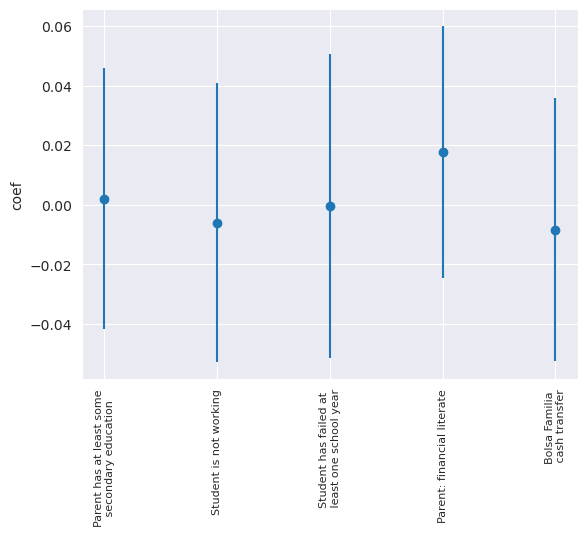

In [18]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(['Parent has at least some\n secondary education ', 'Student is not working', 'Student has failed at\n least one school year', 'Parent: financial literate', 'Bolsa Familia\n cash transfer'])
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1)
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=8)
    ax.set_ylabel('coef')
    plt.savefig("week9.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
# Getting the inference of the coefficients of the CATE model
# together with the corresponding feature names.
est.coef__inference(T=1).summary_frame(feature_names=['Parent has at least some secondary education ', 'Student is not working', 'Student has failed at least one school year', 'Parent: financial literate', 'Bolsa Familia cash transfer'])

In [ ]:
# Getting the inference of the intercept of the CATE model
est.intercept__inference(T=1).summary_frame()

In [ ]:
est.summary(T=1, feature_names=['Parent has at least some secondary education ', 'Student is not working', 'Student has failed at least one school year', 'Parent: financial literate', 'Bolsa Familia cash transfer'])

The $\Phi$ regression is the final model where you are merely training your sudo ATEs on your features and using this trained final model to predict the heterogeneity effects. 

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train the propensity model separately
propensity_model = LogisticRegression(C=1e6).fit(X, T)
propensity_model.fit(X, T)
# Get the propensity scores (probability of being treated)
propensity_scores = propensity_model.predict_proba(X)[:, 1]
# Separate propensity scores for treated and control groups
propensity_scores_treated = propensity_scores[T == 1]
propensity_scores_control = propensity_scores[T == 0]

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(propensity_scores_treated, bins=30, alpha=0.6, color='blue', label='Treated', density=True)
plt.hist(propensity_scores_control, bins=30, alpha=0.6, color='red', label='Control', density=True)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Positivity Check: Distribution of Propensity Scores')
plt.legend()
plt.show()


# Non-Linear Models with Forest CATEs

In [24]:
!pip install econml
from econml.dr import ForestDRLearner
from sklearn.ensemble import GradientBoostingRegressor

est = ForestDRLearner(model_regression=GradientBoostingRegressor(),
                      model_propensity=LogisticRegression(C=1e6).fit(X, T),
                      cv=5,
                      n_estimators=1000,
                      min_samples_leaf=10,#min 10 samples
                      verbose=0, min_weight_fraction_leaf=.01) #min 1% of the total weight of all samples.
est.fit(y, T, X=X)

treatment_effects = est.effect(X)
#95% confidence intervals for the treatment effects
conf_int = est.effect_interval(X)

ate = np.mean(treatment_effects)
ci_lower = np.mean(conf_int[0])
ci_upper = np.mean(conf_int[1])

print("Average Treatment Effect (ATE):", ate)
print("95% Confidence Interval for ATE:", (ci_lower, ci_upper))

ValueError: could not convert string to float: 'dumm_rp_56_bl'

In [135]:
est.feature_importances_(T=1)

array([0.18431703, 0.18468601, 0.24761862, 0.20385046, 0.17952789])

### SHAP: SHapley Additive exPlanations

`shap` is a Python library for **interpretable machine learning** using **SHAP (SHapley Additive exPlanations) values**. SHAP values provide a way to explain the contribution of each feature to a model’s predictions, helping us understand how and why a model makes specific decisions.

#### Key Features of `shap`
1. **Explain Model Predictions**: SHAP values show the impact of each feature on individual predictions, indicating which features push predictions higher or lower.
2. **Global and Local Interpretability**: SHAP can explain both overall feature importance (global) and individual predictions (local), making it versatile for model interpretability.
3. **Compatible with Multiple Models**: It works with a variety of models, including tree-based models, neural networks, and linear models, providing consistent explanations across different model types.
4. **Visualization Tools**: `shap` offers visualizations (e.g., dependence plots, summary plots, and force plots) to make interpreting model behavior intuitive and accessible.

#### Example Usage
The code below demonstrates how to use `shap` to explain a model's predictions. Some notes before we get to see the code:



`background_samples` in shap_values specifies the number of samples from the dataset used as a reference baseline for computing SHAP values. It’s not bootstrapping; rather, it selects a subset of the data to estimate the baseline model behavior to calculate SHAP values relative to this baseline.


`Y0`: The potential outcome under the control condition (or without treatment).

`T0_1`: A specific treatment or intervention effect. `T0_1` often represents the treatment effect of going from treatment level 0 to level 1, which is a common way to label binary treatment effects.



In [ ]:
import shap
# explain the model's predictions using SHAP values
shap_values = est.shap_values(X, feature_names=['Parent has at least some\n secondary education ', 'Student is not working', 'Student has failed at\n least one school year', 'Parent: financial\n literate', 'Bolsa Familia\n cash transfer'], background_samples=100)
shap.summary_plot(shap_values['Y0']['T0_1'])

#### CATE(x) intervals

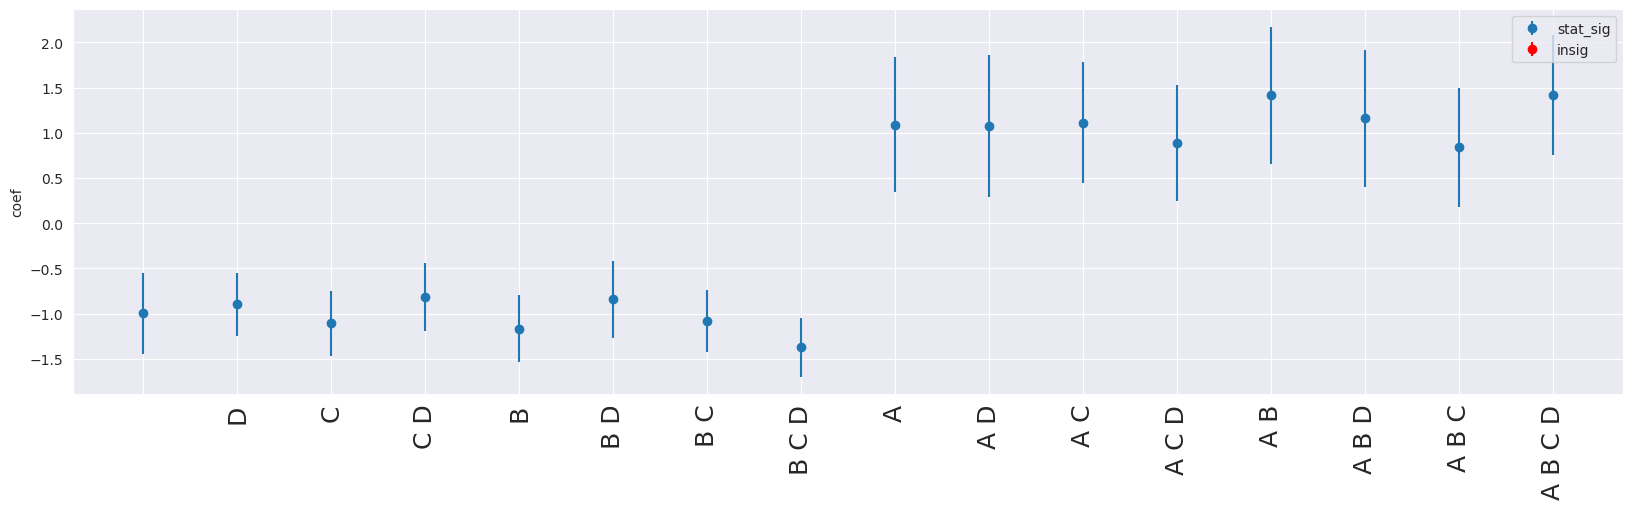

In [81]:
import itertools
# Getting the confidence intervals of the CATE at different X vector values
feat_names = np.array(['A', 'B', 'C', 'D'])
lst = list(itertools.product([0, 1], repeat=4))
point = []
lower = []
upper = []
fnames = []
for x in lst:
    x_test = np.array([x])
    fnames.append(" ".join(np.array(feat_names)[x_test.flatten()>0]))
    point.append(est.effect(x_test)[0])
    lb, ub = est.effect_interval(x_test, alpha=.05)
    lower.append(lb[0])
    upper.append(ub[0])

fnames = np.array(fnames)
point = np.array(point)
lower = np.array(lower)
upper = np.array(upper)
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    x = np.arange(len(point))
    stat_sig = (lower>0) | (upper<0)
    plt.errorbar(x[stat_sig], point[stat_sig], yerr[:, stat_sig], fmt='o', label='stat_sig')
    plt.errorbar(x[~stat_sig], point[~stat_sig], yerr[:, ~stat_sig], fmt='o', color='red', label='insig')
    ax.set_xticks(x)
    ax.set_xticklabels(fnames, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.legend()
    plt.show()

#### CATE(x) inference

In [82]:
# Getting the inference of the CATE at different X vector values
est.effect_inference(X_test[:,:4]).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.158,0.388,2.983,0.003,0.397,1.919
1,-1.109,0.186,-5.974,0.000,-1.473,-0.745
2,1.417,0.339,4.186,0.000,0.754,2.081
3,-1.109,0.186,-5.974,0.000,-1.473,-0.745
4,-1.168,0.189,-6.171,0.000,-1.539,-0.797
5,1.073,0.401,2.678,0.007,0.288,1.858
6,0.888,0.326,2.719,0.007,0.248,1.528
7,-0.898,0.179,-5.028,0.000,-1.248,-0.548
8,0.888,0.326,2.719,0.007,0.248,1.528


In [83]:
# Getting the population inference given sample X
est.effect_inference(X_test[:,:4]).population_summary()

# Tree Interpretation of the CATE Model

In [84]:
from econml.cate_interpreter import SingleTreeCateInterpreter

In [85]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, X[:, :4])

In [86]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [87]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='dr_cate_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'dr_cate_tree.pdf'


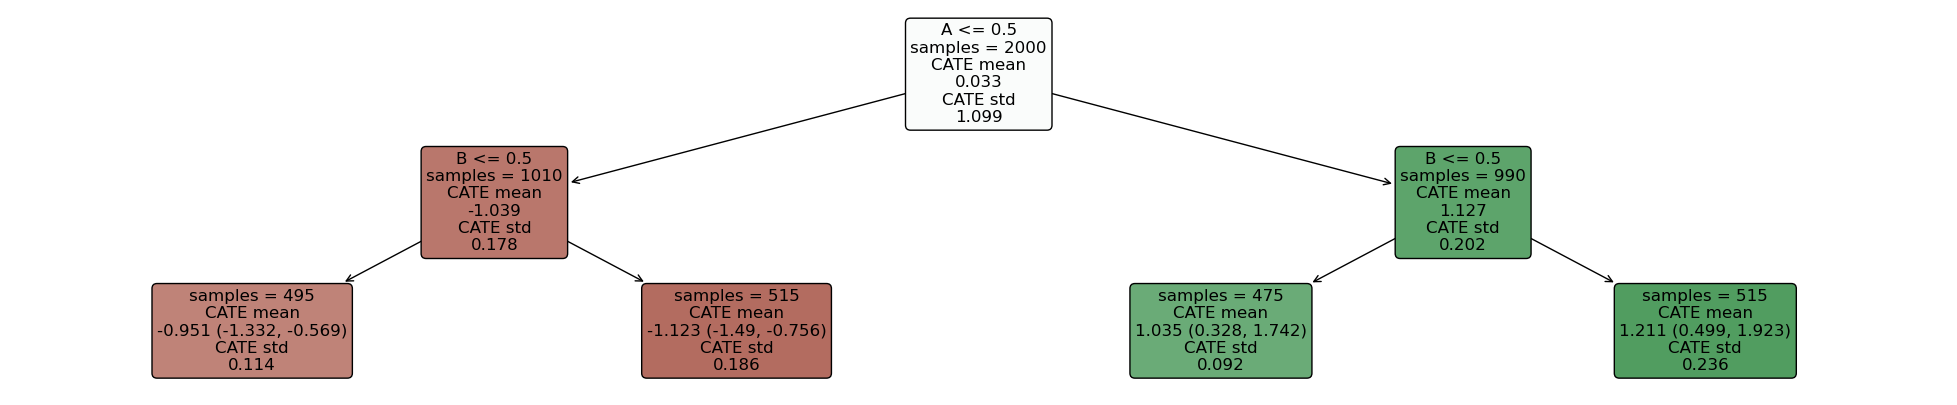

In [88]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# Tree Based Treatment Policy Based on CATE Model

In [89]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [90]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=.001)
# We find a tree based treatment policy based on the CATE model
# sample_treatment_costs is the cost of treatment. Policy will treat if effect is above this cost.
# It can also be an array that has a different cost for each sample. In case treating different segments
# has different cost.
intrp.interpret(est, X[:, :4],
                sample_treatment_costs=0.2)

In [91]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [92]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [93]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='dr_policy_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'dr_policy_tree.pdf'


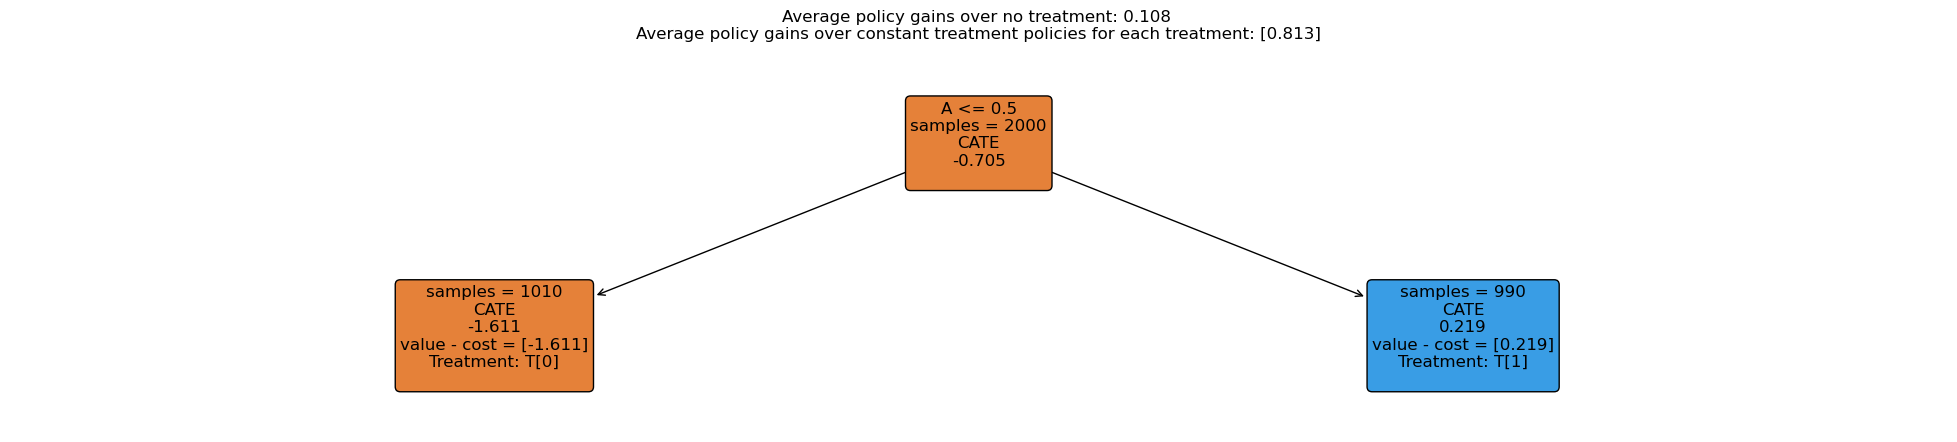

In [94]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# SHAP Interpretability with Final Tree CATE Model

In [95]:
# We need to use a scikit-learn final model
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = DRLearner(model_regression=GradientBoostingRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_propensity=GradientBoostingClassifier(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_final=RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30))
est.fit(y, T, X=X[:, :4], W=X[:, 4:])

In [96]:
import shap
# explain the model's predictions using SHAP values
shap_values = est.shap_values(X[:, :4], feature_names=['A', 'B', 'C', 'D'], background_samples=100)

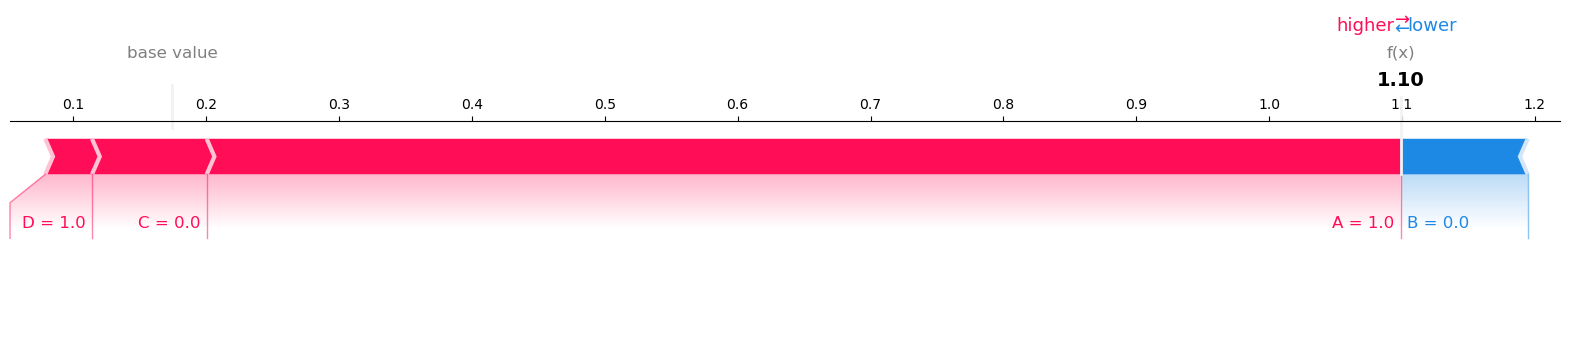

In [97]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(shap_values["Y0"]["T0_1"][0], matplotlib=True)

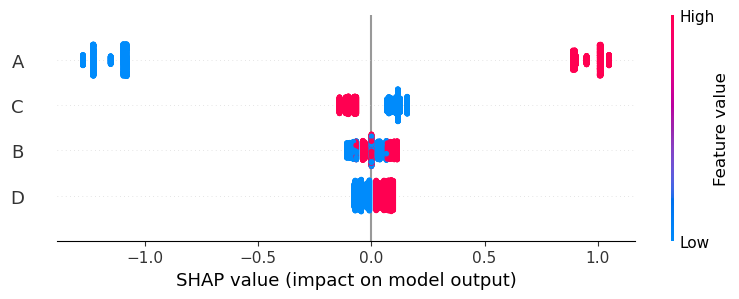

In [98]:
shap.summary_plot(shap_values["Y0"]["T0_1"])